In [4]:
%matplotlib inline

from boututils.datafile import DataFile
from boutdata.collect import collect
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os, sys, pathlib
import platform
import traceback
import xarray
import xbout
import scipy
import re

onedrive_path = onedrive_path = str(os.getcwd()).split("OneDrive")[0] + "OneDrive"
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\sdtools"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages\soledge"))
sys.path.append(os.path.join(onedrive_path, r"Project\python-packages"))

from hermes3.utils import *
# from gridtools.hypnotoad_tools import *
# from gridtools.b2_tools import *
# from gridtools.utils import *

from hermes3.fluxes import *
from hermes3.case_db import *
from hermes3.load import *
from hermes3.named_selections import *
from hermes3.plotting import *
from hermes3.grid_fields import *
from hermes3.accessors import *

from code_comparison.code_comparison import *
from code_comparison.viewer_2d import *


%load_ext autoreload
%autoreload 2


print("Done")


st40_phys_viewer can not be loaded from outside Tokamak Energy!

Gridtools not found
Done


In [2]:
from gridtools.solps_python_scripts.read_b2fgmtry import *

# Hermes IO

In [5]:
casestore = dict()

In [6]:
db = CaseDB()

toload = [
    dict(name="1e19", id="d10d-anom_visc", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    dict(name="2e19", id="d11b-d10d_2e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True),
    # dict(name="3e19", id="d11c-d10d_3e19", grid="g3b2-fatter_newhypno.nc", unnormalise_geom = True)
]

for case in toload:
    casestore[case["name"]] = Load.case_2D(db.casepaths[case["id"]], gridfilepath = db.gridpaths[case["grid"]],
                                           double_load = False, keep_xboundaries = True, keep_yboundaries = True,
                                           unnormalise_geom = case["unnormalise_geom"])

CHECK: Total domain volume is 1.942E+00 [m3]


In [ ]:
plt.close("all")
%matplotlib inline

In [9]:
write_file(casestore, r"C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl")

C:\Users\mikek\OneDrive\Project\collab\tech\notebooks\b1-lineplot-comparison.pkl written


## Read Hermes data

In [ ]:
hr = dict()
for hermes_case in casestore.keys():
    print(hermes_case)
    hr[hermes_case] = Hermesdata()
    hr[hermes_case].read_case(casestore[hermes_case].ds.isel(t=-1, x = slice(2,-2)))

1e19
2e19


# Read SOLEDGE CSV data

In [ ]:
soledgecases = {
    "nocurr_base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\nocurrents_baseline"), # Original case with hydrogen
    "nocore_d" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallStd_bra_nocore_D"), # No ionising core BC, deuterium
    "tightwall" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\soledge_cases\copy_wallMike_bra_nocore_D"),
}

sl = dict()

for name in soledgecases:
    path = soledgecases[name]
    sl[name] = SOLEDGEdata()
    sl[name].read_csv(os.path.join(path, "omp_plasma.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "omp_neutrals.csv"), mode = "plot1d_omp")
    sl[name].read_csv(os.path.join(path, "imp_plasma.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "imp_neutrals.csv"), mode = "plot1d_imp")
    sl[name].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")



In [24]:
path = soledgecases["nocore_d"]
sl["nocore_d"].read_csv(os.path.join(path, "wall_ntmpi_plasma.csv"), mode = "wall_ntmpi")

# Read SOLPS

In [ ]:
solpscases = {
    "base" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5"),
    "noiz_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16"),
    "gammai_2.5" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00"),
    "dpuff_1e22" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22"),
    "dpuff_5e21" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=5.0E+21"),
    "no_fast_reflec" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.Pf=0"),
    "nsep_2e19" : os.path.join(onedrive_path,r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=2E+19"),
    "nsep_3e19" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\.core_extent.b2tqca_phm0=0.nesepm=3E+19"),
    "narrow_core" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent"),
    "no_visc" : os.path.join(onedrive_path, r"Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE_core_extent\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.core_extent.b2tqca_phm0=0")
}

sp = dict()

for name in solpscases:
    sp[name] = SOLPSdata()
    sp[name].read_last10s(solpscases[name])

c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.GAMMAI=2.5E+00\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\compare_data\playAround_ST40_IVC2_HERMES_SOLEDGE\HERMES_SOLEDGE.S33600_Tamb_case.SEE=0.BGK=OFF.SOLEDGE.reactions.input.dat.OK.Js=OFF.GAMMAE=4.5.eirene_ionising_core=0.BCCON=16.D2PUFF=1.0E+22\last10s.pkl loaded
c:\Users\mikek\OneDrive\Project\collab\tech\co

## Plots

## Lineplots

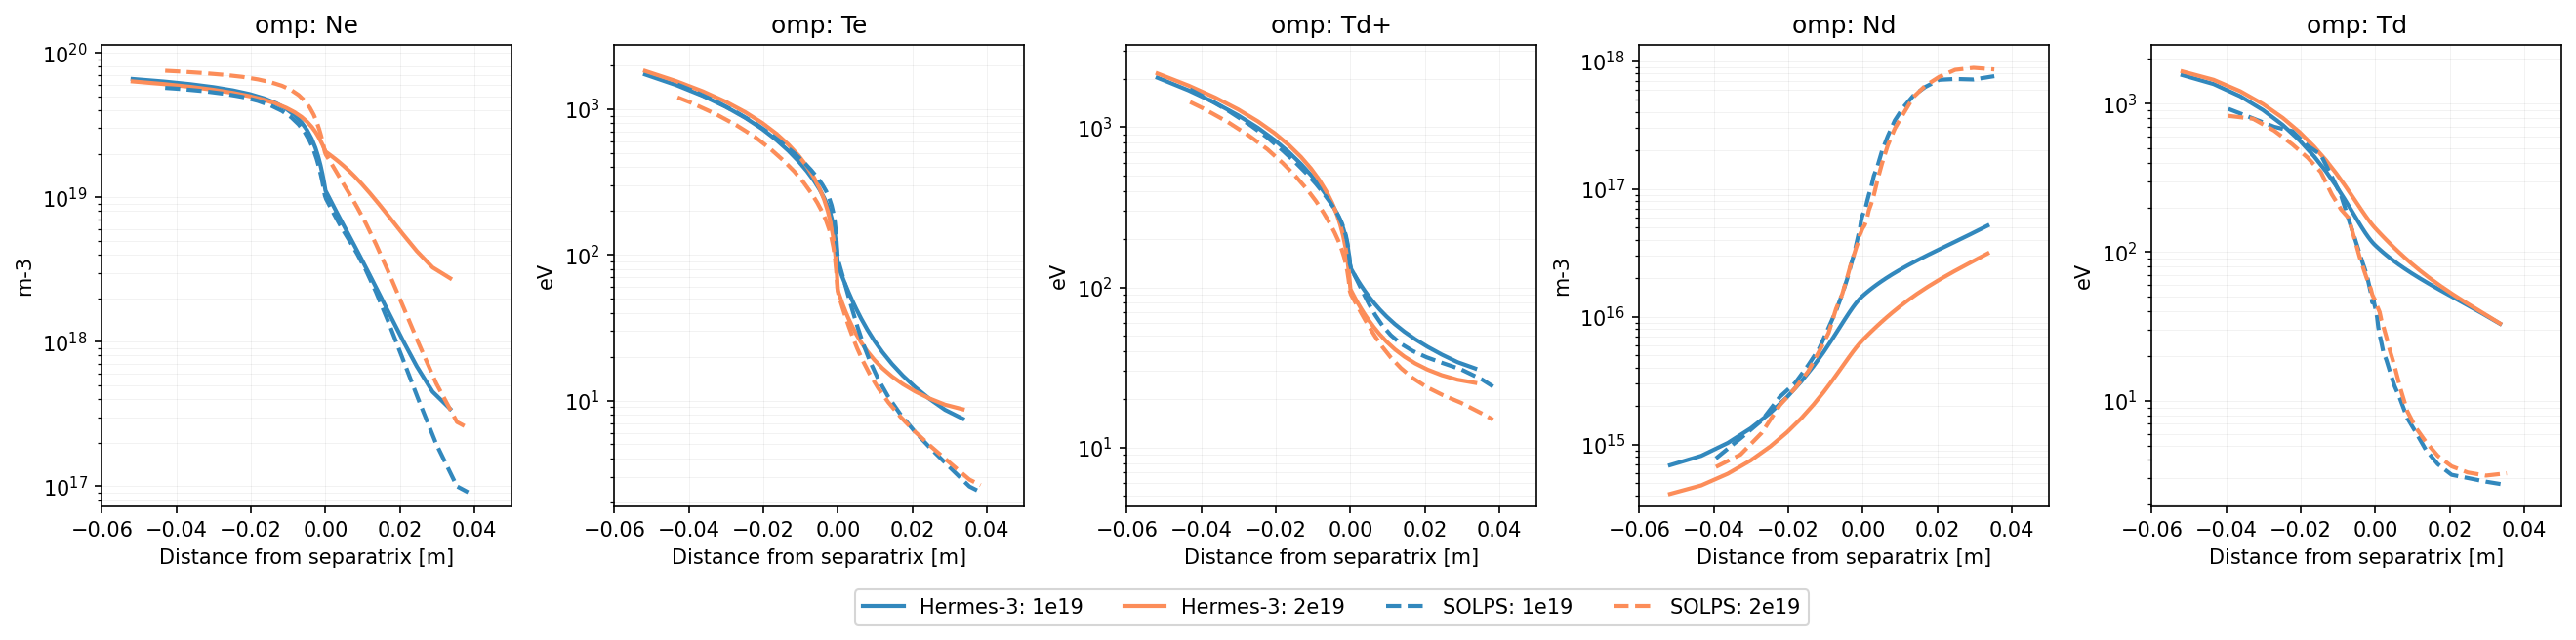

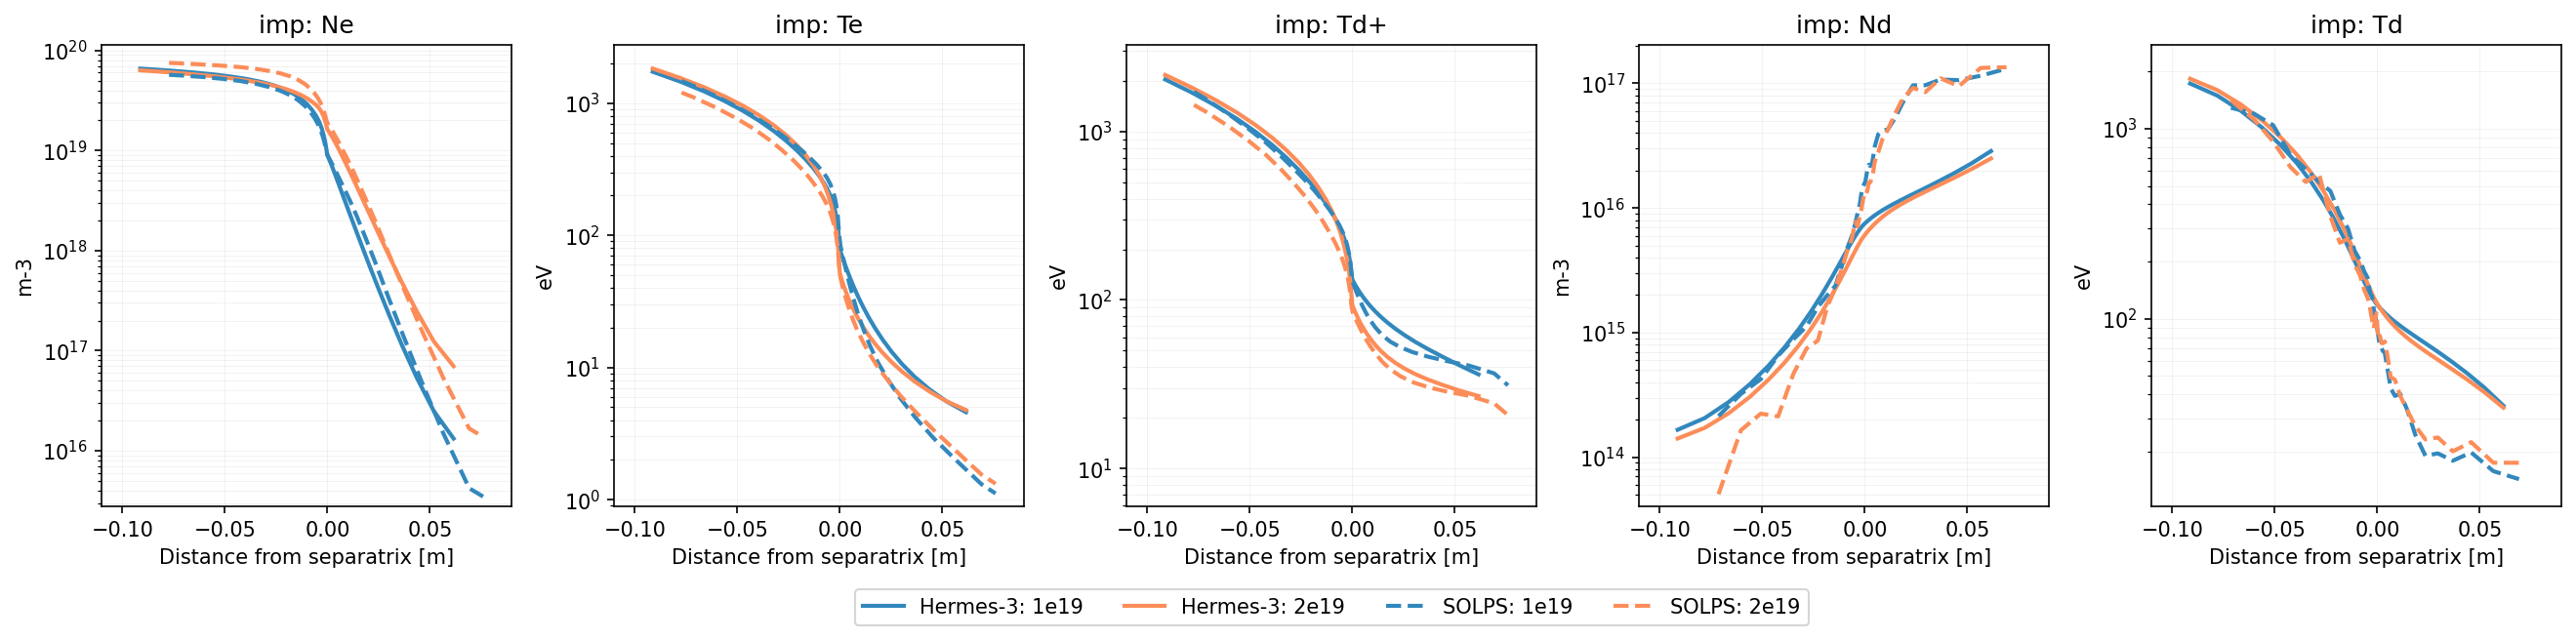

In [42]:

plt.close("all")
lineplot_compare(
    cases = { 
             
    "Hermes-3: 1e19": dict(data=hr["1e19"], color="#3288bd"),
    "Hermes-3: 2e19": dict(data=hr["2e19"], color="#fc8d59"),
    # "Hermes-3: 3e19": dict(data=hr["3e19"], color="#fc8d59"),
    
    "SOLPS: 1e19" : dict(data=sp["no_visc"], color="#3288bd"),
    "SOLPS: 2e19" : dict(data=sp["nsep_2e19"], color="#fc8d59"),
    # "SOLPS: 3e19" : dict(data=sp["nsep_3e19"], color="#fc8d59"),
    
    # "Hermes-3: Tn_sol=30eV" : dict(data=hr["tn30"], color="teal"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03_nonsepfit"], color="darkorange"),
    # "Hermes-3: Tn_sol=0.03eV" : dict(data=hr["tn0.03"], color="darkorange"),
    
    },
    # regions = ["omp", "imp"], params = ["Ne", "Td+", "Te"],
    # regions = ["omp", "imp"], params = ["Nd", "Td", "Sd+_iz"],
    regions = ["omp", "imp"], params = ["Ne", "Te", "Td+", "Nd", "Td"],
    # regions = ["omp", "imp", "outer_lower"], params = ["Nd", "Td"],
    # regions = ["omp"], params = []
    mode = "log",
    dpi = 150,
    lw = 2
)

## 2D plots

['Densi', 'Tempi', 'velocityi', 'IRadi', 'NRadi', 'Sni', 'SEi', 'SGi', 'Nni', 'Tni', 'vxni', 'vyni', 'vzni', 'Nmi', 'Tmi', 'Pni', 'vxmi', 'vymi', 'vzmi', 'Ntii', 'Pni', 'TotRadi', 'Mi', 'Ppi', 'Epi', 'TDensi', 'TDensei', 'FracDensi', 'Cimpi', 'FracDensei', 'Zavei']
SOLEDGE: Combining Nmi and Nni


c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


b2fgmtry loaded from .pkl


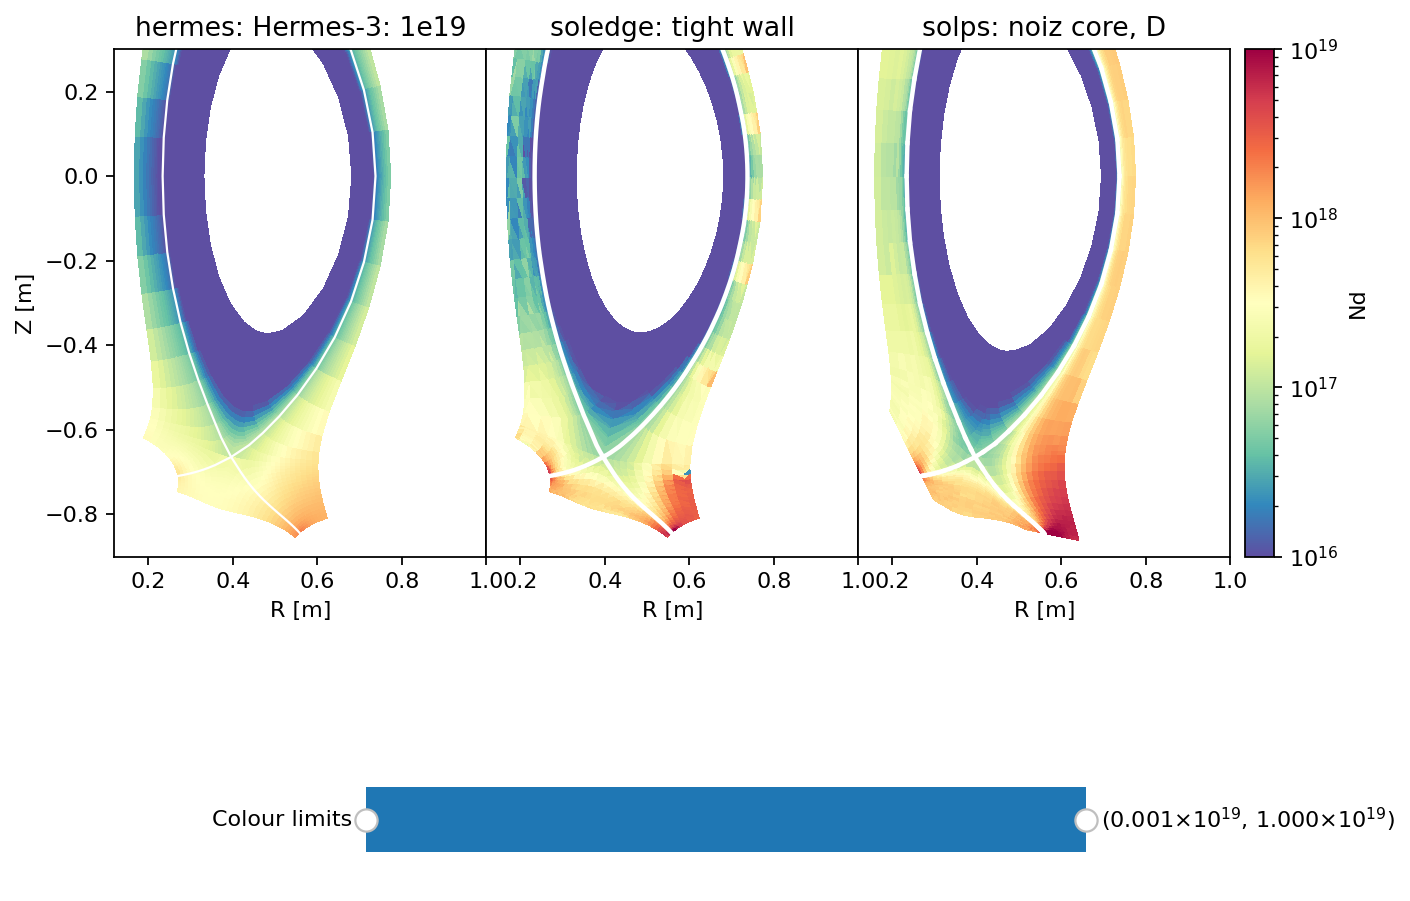

In [28]:
v = viewer_2d(
    "Nd",
    [
        {"name" : "Hermes-3: 1e19", "code" : "hermes", "ds" : casestore["1e19"].ds.isel(t=-1)},
        {"name" : "tight wall", "code":"soledge", "path" : soledgecases["tightwall"]},
        {"name": "noiz core, D", "code":"solps", "path" : solpscases['no_visc']}
    ],
    logscale = True,
    # vmin = 10,
    # vmax = 100,
    vmin = 1e16,
    vmax = 1e19,
    dpi = 160,
    ylim = (-0.9,0.3),
    xlim = (0.12, 1.0),
    wspace = 0.0,
    cmap = "Spectral_r"
)

In [ ]:
from code_comparison.solps_pp import *
params = ["Ne"]


self = SOLPScase(solpscases["nsep_2e19"])

region = "outer"
dist_from_sep = 0.001

if "outer" in region:
    radial_locator = self.s["omp"]
elif "inner" in region:
    radial_locator = self.s["imp"]
else:
    raise Exception(f"Region {region} not recognised")

p = radial_locator
radial_dist = self.g["R"][p[0], p[1]] - self.g["R"][p[0], self.g["sep"]] 
ring_index = np.argmin(abs(dist_from_sep - radial_dist))
ring_from_sep = ring_index - self.g["sep"]
print(f"Distance {dist_from_sep} corresponds to SOL ring {ring_from_sep}")    

# Get slice of the separatrix for the requested region
p = self.s[region]
p[1] += ring_from_sep   # Advance to desired SOL ring

poloidal_dist = 

dpi = 150
fig, axes = plt.subplots(2,len(params), dpi = dpi, figsize = (4.2*len(params),5), sharex = True)
fig.subplots_adjust(hspace = 0, wspace = 0.25, bottom = 0.25, left = 0.1, right = 0.9)

ax = axes[0]
ax.plot(dist, self.bal["ne"][:][p[0], p[1]])

In [61]:
for name in casestore:
    casestore[name].ds = calculate_radial_fluxes(casestore[name].ds)

# Diffusivity

In [15]:
ds = casestore["2e19"].ds

ds = calculate_radial_fluxes(ds)

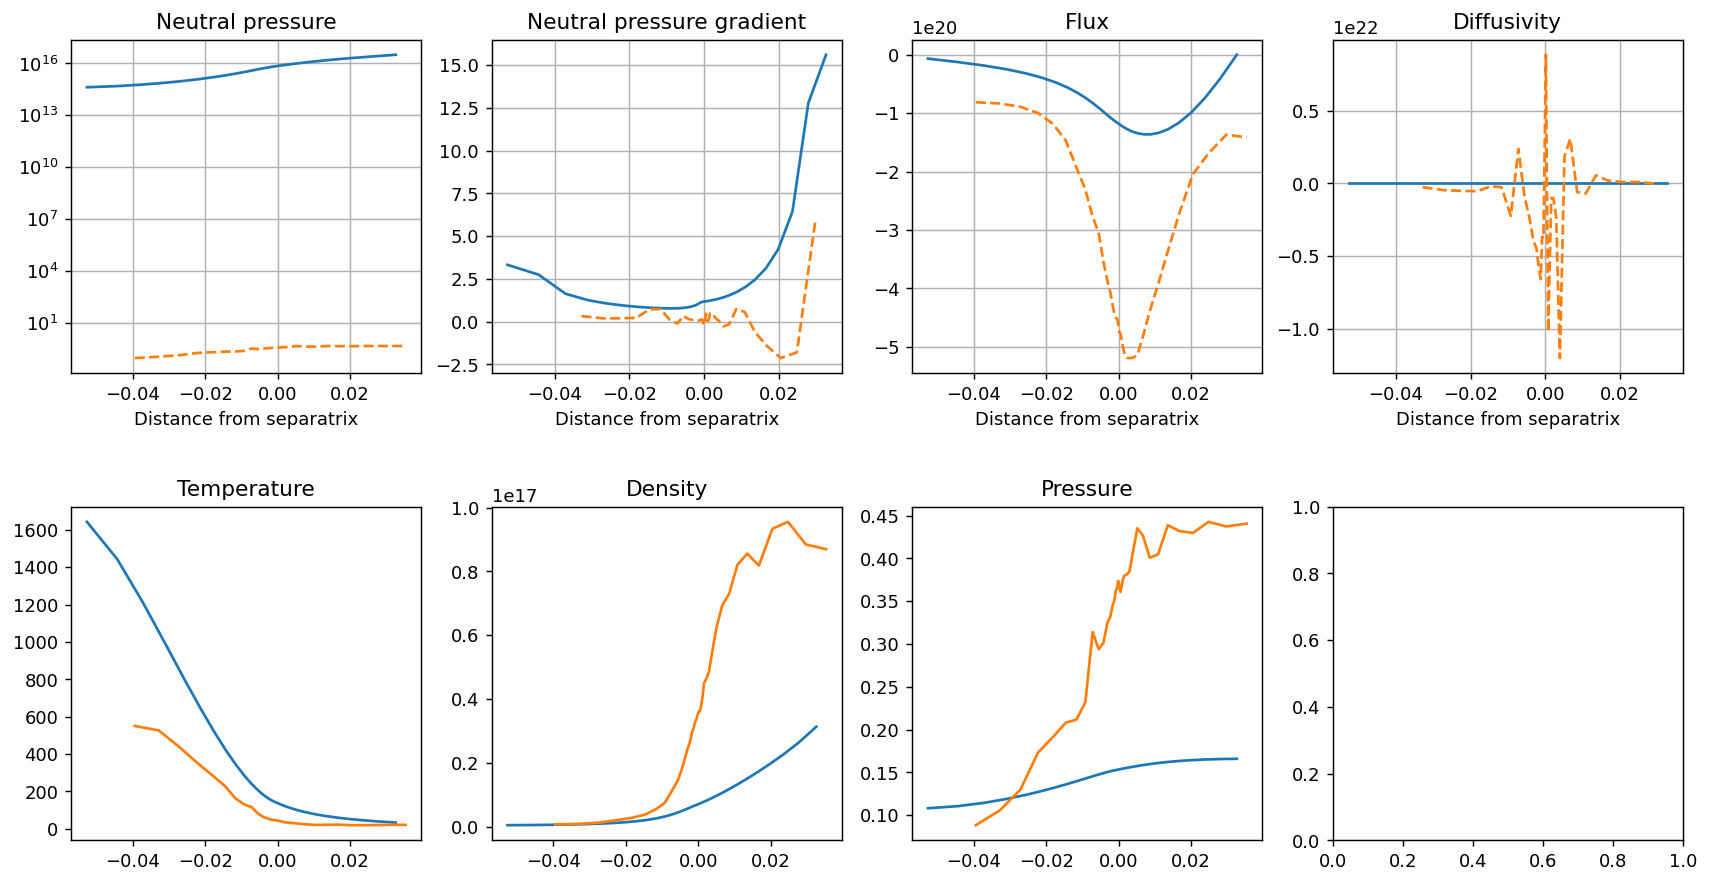

In [34]:
class Hplot():
    def __init__(self, ds):
        self.omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
        self.dist = self.omp["R"]-self.omp["R"][ds.metadata["ixseps1"]]
    def plot_pn(self, ax, **kwargs):
        ax.plot(self.dist, self.omp["Nd"], **kwargs)
    def plot_grad_nd(self, ax, **kwargs):
        ax.plot(self.dist, np.gradient(self.dist, self.omp["Nd"]), **kwargs)
    def plot_grad_pd(self, ax, **kwargs):
        ax.plot(self.dist, np.gradient(self.dist, self.omp["Pd"]), **kwargs)
    def plot_dn(self, ax, **kwargs):
        ax.plot(self.dist, self.omp["Dnnd"], **kwargs)
    def plot_tn(self, ax, **kwargs):
        ax.plot(self.dist, self.omp["Td"], **kwargs)
    def plot_npflux(self, ax, **kwargs):
        area_yz = self.omp["J"] * self.omp["g11"]
        pflux = self.omp["pf_perp_diff_R_d"] / area_yz
        ax.plot(self.dist, pflux, **kwargs)
    
    def plot_var(self, ax, var, **kwargs):
        ax.plot(self.dist, self.omp[var], **kwargs)
        
class Splot():
    def __init__(self, case):
        self.place = case.regions["omp"]
        self.dist = omp.index
    def plot_na(self, ax, **kwargs):
        ax.plot(self.dist, self.place["dab23da"], **kwargs)
    def plot_pa(self, ax, **kwargs):
        ax.plot(self.dist, self.place["pab23da"], **kwargs)
    def plot_nn(self, ax, **kwargs):
        ax.plot(self.dist, self.place["dnb23da"], **kwargs)
    def plot_grad_na(self, ax, **kwargs):
        ax.plot(self.dist, np.gradient(self.dist, self.place["dab23da"]), **kwargs)
    def plot_grad_pa(self, ax, **kwargs):
        ax.plot(self.dist, np.gradient(self.dist, self.place["pab23da"]), **kwargs)
    def plot_apflux(self, ax, **kwargs):
        ax.plot(self.dist, -self.place["rfluxa3da"], **kwargs)
    def plot_dn(self, ax, **kwargs):
        dn = -self.place["rfluxa3da"] / np.gradient(self.dist, self.place["pab23da"])
        ax.plot(self.dist, dn, **kwargs)
        
    def plot_var(self, ax, var, **kwargs):
        ax.plot(self.dist, self.place[var], )
        
    

omp = sp["narrow_core"].regions["omp"]
Nd = omp["dab23da"]
flux = omp["rfluxa3da"]
grad_Nd = np.gradient(omp.index, Nd)
Dn = -grad_Nd / flux
# ax.plot(dist, -1*(casestore["1e19"].ds["Dnnd"]), label = "Hermes-3: 1e19", color = "#2b83ba", lw=2)
# ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)

# ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["rfluxa3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

fig, axes = plt.subplots(2,4, figsize = (16,8), dpi = 130)
fig.subplots_adjust(hspace=0.4)
h = Hplot(ds)
s = Splot(sp['nsep_2e19'])
h.plot_pn(axes[0,0])
h.plot_grad_pd(axes[0,1])
h.plot_npflux(axes[0,2])
h.plot_dn(axes[0,3])

s.plot_pa(axes[0,0], ls="--")
s.plot_grad_pa(axes[0,1], ls="--")
s.plot_apflux(axes[0,2], ls="--")
s.plot_dn(axes[0,3], ls="--")

h.plot_var(axes[1,0], "Td")
h.plot_var(axes[1,1], "Nd")
h.plot_var(axes[1,2], "Pd")

s.plot_var(axes[1,0], "tab23da", ls = "--")
s.plot_var(axes[1,1], "dab23da", ls = "--")
s.plot_var(axes[1,2], "pab23da", ls = "--")
# hplot_grad_nd(axes[1], casestore["1e19"].ds, label = "Hermes-3: 1e19", color = "#2b83ba")
# splot_grad_nd(axes[1], sp["nsep_2e19"], label = "SOLPS:1e19", color = "darkorange", ls="--")

axes[0,0].set_yscale("log")
axes[0,0].set_title("Neutral pressure")
axes[0,1].set_title("Neutral pressure gradient")
axes[0,2].set_title("Flux")
axes[0,3].set_title("Diffusivity")

axes[1,0].set_title("Temperature")
axes[1,1].set_title("Density")
axes[1,2].set_title("Pressure")

for ax in axes[0,:]:
    # ax.legend(fontsize=8)    
    ax.grid()
    ax.set_xlabel("Distance from separatrix")


# ax.set_ylabel("Diffusivity [m2s-1]")

## Interpolate pressure and extract diffusion

## Extracting pressure gradient

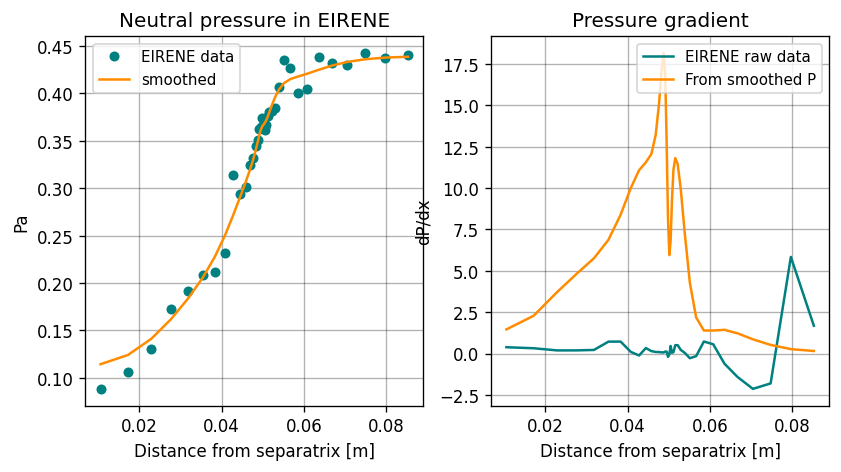

In [ ]:
from sd1d.analysis import AMJUEL
rtools = AMJUEL()

def smooth(x,w,recursion=0):
    out = scipy.ndimage.gaussian_filter(x, w)
    for i in range(recursion):
        out = scipy.ndimage.gaussian_filter(out, w)
    return out

fig, axes = plt.subplots(1,2, figsize=(8,4), dpi = 120)

sdata = sp['nsep_2e19'].regions["omp"]
dist = sdata.index[1:-1] + 0.05
sPa = sdata["pab23da"].iloc[1:-1]
sPa_fun = scipy.interpolate.CubicSpline(dist, sPa)

sPa_smooth = smooth(sPa,1, recursion=3)
grad_sPa = np.gradient(dist, sPa)
grad_sPa_smooth = np.gradient(sPa_smooth, dist)



axes[0].plot(dist, sPa, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[0].plot(dist, sPa_smooth, color = "darkorange", label = "smoothed")
axes[0].set_ylabel("Pa")
axes[0].set_title("Neutral pressure in EIRENE")
axes[1].plot(dist, grad_sPa, color = "teal", label = "EIRENE raw data")
axes[1].plot(dist, grad_sPa_smooth, color = "darkorange", label = "From smoothed P")
axes[1].set_ylabel("dP/dx")
axes[1].set_title("Pressure gradient")


for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=9)

### Treating density and temperature separately

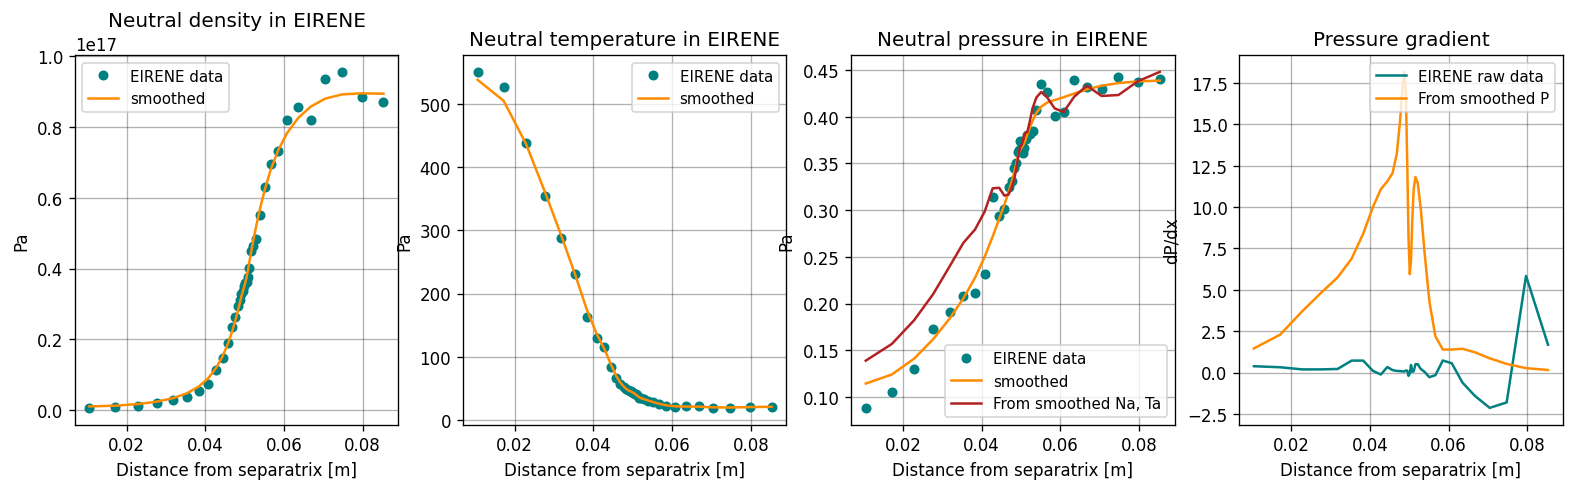

In [ ]:
from sd1d.analysis import AMJUEL
rtools = AMJUEL()

def smooth(x,w,recursion=0):
    out = scipy.ndimage.gaussian_filter(x, w)
    for i in range(recursion):
        out = scipy.ndimage.gaussian_filter(out, w)
    return out

fig, axes = plt.subplots(1,4, figsize=(16,4), dpi = 120)

sdata = sp['nsep_2e19'].regions["omp"]
dist = sdata.index[1:-1] + 0.05
sPa = sdata["pab23da"].iloc[1:-1]
sPa_fun = scipy.interpolate.CubicSpline(dist, sPa)
Te = sdata["te3da"].iloc[1:-1].values
Ne = sdata["ne3da"].iloc[1:-1].values
Na = sdata["dab23da"].iloc[1:-1].values
Ta = sdata["tab23da"].iloc[1:-1].values   # Atoms
Pa = sdata["pab23da"].iloc[1:-1].values

sPa_smooth = smooth(sPa,1, recursion=3)
Na_smooth = smooth(Na, 1, recursion=3)
Ta_smooth = smooth(Ta, 0.5, recursion=3)
sPa_fromsmoothed = Na_smooth * Ta_smooth * constants("q_e") * 3/2
sPa_calc = Na * Ta * constants("q_e") * 3/2
grad_sPa = np.gradient(dist, sPa)
grad_sPa_smooth = np.gradient(sPa_smooth, dist)

axes[0].plot(dist, Na, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[0].plot(dist, Na_smooth, color = "darkorange", label = "smoothed")
axes[0].set_ylabel("Pa")
axes[0].set_title("Neutral density in EIRENE")

axes[1].plot(dist, Ta, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[1].plot(dist, Ta_smooth, color = "darkorange", label = "smoothed")
axes[1].set_ylabel("Pa")
axes[1].set_title("Neutral temperature in EIRENE")

axes[2].plot(dist, sPa, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[2].plot(dist, sPa_smooth, color = "darkorange", label = "smoothed")
axes[2].plot(dist, sPa_fromsmoothed, color = "firebrick", label = "From smoothed Na, Ta")
# axes[2].plot(dist, sPa_calc, color = "firebrick", lw = 0, marker = "o", ms = 5, label = "Na * Ta")
axes[2].set_ylabel("Pa")
axes[2].set_title("Neutral pressure in EIRENE")
axes[3].plot(dist, grad_sPa, color = "teal", label = "EIRENE raw data")
axes[3].plot(dist, grad_sPa_smooth, color = "darkorange", label = "From smoothed P")
axes[3].set_ylabel("dP/dx")
axes[3].set_title("Pressure gradient")


for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=9)

## Capturing collisions

In [149]:
constants("q_e")

1.60217662e-19

In [3]:


vth_a = np.sqrt(constants("q_e") * (Ta)/(constants("mass_p")*2))   # Atom sound speed
Kcx = [rtools.amjuel_1d("H.2 3.1.8", x) for x in Te]
nu_iz = np.zeros_like(Ta)
nu_cx = np.zeros_like(Ta)

for i, _ in enumerate(dist):
    nu_iz[i] = rtools.amjuel_2d("H.4 2.1.5", Te[i], Ne[i]) * Ne[i]
    nu_cx[i] = rtools.amjuel_1d("H.2 3.1.8", Te[i]) * Ne[i]

# ----- NN rate (from SD1D):
a0 = np.pi * 5.29e-11**2
lambda_nn = 1/(Na*a0)
for i, _ in enumerate(lambda_nn):
    if lambda_nn[i] > 0.1:
        lambda_nn[i] = 0.1
nu_nn = vth_a / lambda_nn


# sDn = vth_a**2 / (nu_cx + nu_iz) 
sDn_cx =  1/((nu_cx) * constants("mass_p")*2)
sDn_izcx =  1/((nu_cx + nu_iz) * constants("mass_p")*2)
sDn_cxnn =  1/((nu_cx + nu_nn) * constants("mass_p")*2)
sDn_izcxnn =  1/((nu_cx + nu_iz + nu_nn) * constants("mass_p")*2)

flux = sdata["rfluxa3da"].iloc[1:-1]
sDn_effective = flux / grad_sPa_smooth



def flux_limiter(flux, gamma=1, alpha=1):
    return flux * (1+ (flux / (alpha*flim))**gamma)**(-1/gamma)
    

flux_sDn_izcxnn = sDn_izcxnn * grad_sPa_smooth
flux_sDn_izcx = sDn_izcx * grad_sPa_smooth
flux_sDn_cxnn = sDn_cxnn * grad_sPa_smooth
flux_sDn_cx = sDn_cx * grad_sPa_smooth

# Flux limiter
gamma = 1
alpha = 1
flim = Na * 1/4 * np.sqrt( (8*Ta) / (np.pi * constants("mass_p")*2) )
flux_limited = flux_sDn_izcxnn * (1+ (flux_sDn_izcxnn / (alpha*flim))**gamma)**(-1/gamma)

fig, axes = plt.subplots(1,3, figsize=(12,4), dpi = 120)

axes[0].plot(dist, nu_iz, color = "teal", label = "IZ")
axes[0].plot(dist, nu_cx, color = "darkorange", label = "CX")
axes[0].plot(dist, nu_nn, color = "firebrick", label = "NN")
axes[0].set_ylabel("Frequency [s-1]")
axes[0].set_title("Collisionalities in SOLPS")
axes[0].set_yscale("log")

axes[1].plot(dist, sDn_effective, color = "teal", label = "Inferred diffusivity")
axes[1].plot(dist, sDn_izcxnn, color = "darkorange", label = "Diffusivity from IZ/CX/NN")
axes[1].plot(dist, sDn_cxnn, color = "darkorange", ls = "--", label = "Diffusivity from CX/NN")
axes[1].plot(dist, sDn_cx, color = "darkorange", ls = ":", label = "Diffusivity from CX")
axes[1].set_title("Diffusivities")
axes[1].set_yscale("log")

axes[2].plot(dist, flux, color = "teal", label = "EIRENE neutral flux")
axes[2].plot(dist, flux_limited, color = "darkorange", label = "IZ/CX/NN + limiter")
axes[2].plot(dist, flux_sDn_izcxnn, color = "darkorange", label = "IZ/CX/NN")
axes[2].plot(dist, flux_sDn_cxnn, color = "darkorange", ls = "--", label = "CX/NN")
axes[2].plot(dist, flux_sDn_cx, color = "darkorange", ls = ":", label = "CX")
axes[2].set_title("Fluxes")
axes[2].set_yscale("log")


# axes[1].set_yscale("log")
for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=7)

NameError: name 'constants' is not defined

In [2]:
import numpy as np
np.sqrt(np.pi)

1.7724538509055159

# Repeat for SOLEDGE

In [ ]:
from soledge.wrapper_class import *
slc = soledge.wrapper_class.SOLEDGEcase(r"C:\Users\mikek\OneDrive\Project\collab\tech\compare_data\soledge_cases\ST40_wallMike_bra_nocore_D_2e19")

c:\Users\mikek\OneDrive\Project\python-packages\soledge\routines\h5_routines.py:65: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  Data = Data.astype(np.str)


### Get data

In [27]:
dfs = []

dist = slc.get_1d_radial_data("Dense")["dist"].values
Ne = slc.get_1d_radial_data("Dense")["Dense"].values
Na = slc.get_1d_radial_data("Nni")["Nni"].values
Te = slc.get_1d_radial_data("Tempe")["Tempe"].values
Ta = slc.get_1d_radial_data("Tni")["Tni"].values
Vxa = slc.get_1d_radial_data("vxni")["vxni"].values
Pa = Na * Ta * constants("q_e") * 3/2
flux = Na * Vxa   # m-2s-1

### Pressure gradient

In [30]:
plt.close("all")
%matplotlib inline

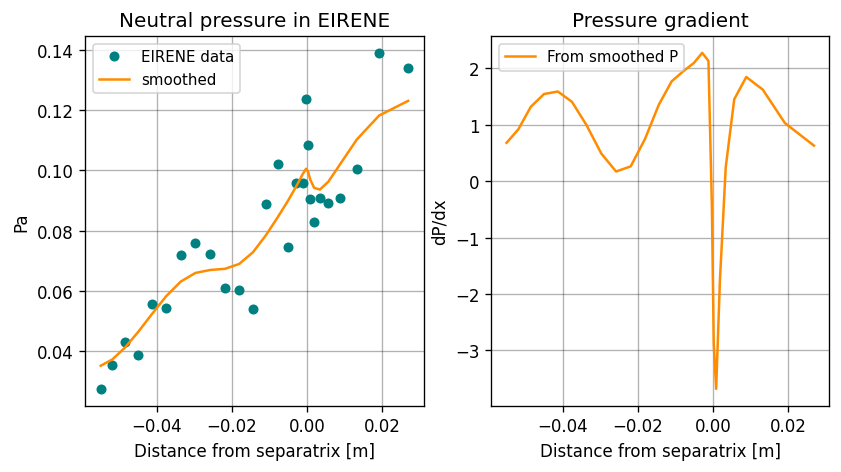

In [32]:
from sd1d.analysis import AMJUEL
rtools = AMJUEL()

def smooth(x,w,recursion=0):
    out = scipy.ndimage.gaussian_filter(x, w)
    for i in range(recursion):
        out = scipy.ndimage.gaussian_filter(out, w)
    return out

fig, axes = plt.subplots(1,2, figsize=(8,4), dpi = 120)


Pa_fun = scipy.interpolate.CubicSpline(dist, Pa)

Pa_smooth = smooth(Pa,1, recursion=3)
grad_Pa = np.gradient(dist, Pa)
grad_Pa_smooth = np.gradient(Pa_smooth, dist)



axes[0].plot(dist, Pa, color = "teal", lw = 0, marker = "o", ms = 5, label = "EIRENE data")
axes[0].plot(dist, Pa_smooth, color = "darkorange", label = "smoothed")
axes[0].set_ylabel("Pa")
axes[0].set_title("Neutral pressure in EIRENE")
# axes[1].plot(dist, grad_Pa, color = "teal", label = "EIRENE raw data")
axes[1].plot(dist, grad_Pa_smooth, color = "darkorange", label = "From smoothed P")
axes[1].set_ylabel("dP/dx")
axes[1].set_title("Pressure gradient")


for ax in  axes:
    ax.set_xlabel("Distance from separatrix [m]")
    ax.grid(color = "k", alpha = 0.3)
    ax.legend(fontsize=9)

In [8]:
sl.keys()

dict_keys(['nocurr_base', 'nocore_d', 'tightwall'])

In [24]:
slc.get_1d_radial_data("Dense")

,dist,R,Z,Dense
0,-0.054912,0.682682,-0.002436,5.860209e+19
1,-0.051773,0.685821,-0.002436,5.776449e+19
2,-0.048441,0.689153,-0.002436,5.685817e+19
3,-0.044931,0.692663,-0.002436,5.588251e+19
4,-0.041269,0.696325,-0.002436,5.482974e+19
5,-0.037485,0.700108,-0.002436,5.368644e+19
6,-0.033612,0.703982,-0.002436,5.243547e+19
7,-0.029687,0.707907,-0.002436,5.105124e+19
8,-0.025750,0.711844,-0.002436,4.950044e+19
9,-0.021850,0.715744,-0.002436,4.772505e+19


In [155]:
Ne * Te 

array([8.21729129e+22, 6.69431913e+22, 5.42507403e+22, 4.39020603e+22,
       3.49384129e+22, 2.76914516e+22, 2.19861678e+22, 1.73108552e+22,
       1.35357770e+22, 1.05449600e+22, 8.19416123e+21, 6.35181142e+21,
       4.92178562e+21, 3.83939515e+21, 3.02158760e+21, 2.36686451e+21,
       1.78986444e+21, 1.21063392e+21, 1.03804203e+21, 9.50992245e+20,
       8.69363411e+20, 7.84777782e+20, 6.91265095e+20, 5.87919285e+20,
       4.78771821e+20, 3.71276137e+20, 2.73972793e+20, 1.92435470e+20,
       1.28064124e+20, 7.99108142e+19, 4.58904145e+19, 2.39717241e+19,
       1.13675438e+19, 4.90351993e+18, 1.95767040e+18, 7.95678653e+17])

In [45]:
fun = scipy.interpolate.UnivariateSpline(sdata.index, sPa)
fun(1
    )

array(nan)

# Radial flux analysis

In [58]:
def makeflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["pf_perp_diff_R_d"] / area_yz
    return hflux

def makehflux(ds):
    omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
    area_yz = omp["J"] * omp["g11"]
    hflux = omp["hf_perp_diff_R_d"] / area_yz
    return hflux

omp = ds.hermesm.select_region("outer_midplane_a").isel(t=-1, x = slice(2,-2))
dist = omp["R"]-omp["R"][ds.metadata["ixseps1"]]

KeyError: 'pf_perp_diff_R_d'

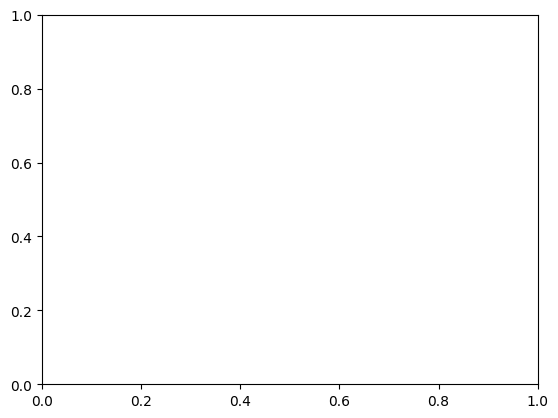

In [59]:
fig, ax = plt.subplots()
ax.plot(dist, -1*(makeflux(casestore["1e19"].ds)), label = "Hermes-3: 1e19", color = "#2b83ba", lw=2)
ax.plot(dist, -1*(makeflux(casestore["2e19"].ds)), label = "Hermes-3: 2e19", color = "darkorange", lw=2)
ax.plot(sp["narrow_core"].regions["omp"].index, sp["narrow_core"].regions["omp"]["rfluxa3da"], label = "SOLPS: 1e19", color = "#2b83ba", lw=2, ls="--")
ax.plot(sp["nsep_2e19"].regions["omp"].index, sp["nsep_2e19"].regions["omp"]["rfluxa3da"], label = "SOLPS: 2e19", color = "darkorange", lw=2, ls = "--")

ax.legend()
ax.grid()
ax.set_title("Radial neutral transport")
ax.set_xlabel("Distance from separatrix")
ax.set_ylabel("Radial neutral flux [m-2s-1]")

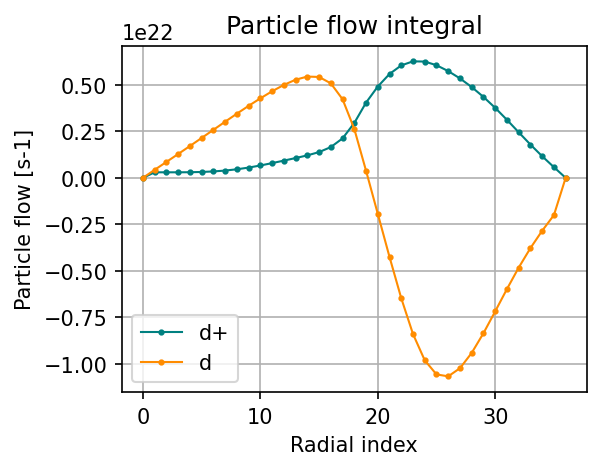

In [16]:
plot_perp_particle_fluxes(ds.isel(t=-1))